In [148]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [149]:
dev = qml.device("default.qubit",wires=8)

In [150]:
def Ue(x,i):
    #print("x inside rx",x)
    qml.RX(x,wires=i)
    
def U1(p1,p2,i,j):
    qml.CRX(p1,wires=[i,j])
    qml.CRX(p2,wires=[j,i])
    
def U2(p,c):
    for k in range(c):
        qml.CRX(p[k],wires=[k,(k+1)%c])

In [151]:
def layer(layer_weights):
    #qml.Hadamard(wires=0)
    #qml.Hadamard(wires=1)
    for wire in range(4):
        qml.RY(layer_weights[wire], wires=[wire])
    for i in range(4):
        qml.CNOT(wires=[i, (i+1)%4])
    #qml.Hadamard(wires=0)
    #qml.Hadamard(wires=1)
    #print(qml.state())

In [152]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2])

    #return x


def state_preparation(a):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.Hadamard(wires=3)

    qml.CNOT(wires=[0, 1])
    #qml.RX(a[1], wires=1)
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    
    qml.CNOT(wires=[1,2])
    #qml.RX(a[2], wires=2)
    qml.RY(a[2], wires=2)
    qml.CNOT(wires=[1,2])
    
    
    #qml.PauliX(wires=0)
    
    qml.CNOT(wires=[2, 3])
    #qml.RX(a[3], wires=3)
    qml.RY(a[3], wires=3)
    qml.CNOT(wires=[2, 3])
    
    
    qml.CNOT(wires=[3,0])
    #qml.RX(a[0], wires=0)
    qml.RY(a[0], wires=0)
    qml.CNOT(wires=[3,0])
    #qml.RY(a[4], wires=1)
    #qml.PauliX(wires=0)
    
    
    
    

In [153]:
@qml.qnode(dev)
def circuit_final(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)
    #
    
    return qml.expval(qml.PauliZ(0))  #np.array([qml.expval(qml.PauliZ(i)) for i in range(4)]) #qml.expval(qml.PauliZ(0))  #qml.state()

In [154]:
@qml.qnode(dev)
def circuit(p, q,k,t):
    #state_preparation(x)

    #for t in range(4):
        # Ue encoding
    #print("----------",t)
    #print("q.shape,k.shape",q.shape,k.shape)
    for n in range(4):
        #print("q[t', k[n],",q[t].shape,k[n].shape,q[t],k[n])
        Ue( q[t], n*2 )
        Ue( k[n], n*2 )
        
    #print('encoding done')
         
        # U1 construction
    for y in range(2):
        U1( p[y*2],p[y*2+1], y*2 , y*2 +1 )
            
        
        # U2 construction    
    U2(p[8:16],8)
        
    #print('first layer done')
    #
    #print('all layers done')
    return qml.expval(qml.PauliZ(0)) #np.array([qml.expval(qml.PauliZ(i)) for i in range(0,32,8)]) #qml.expval(qml.PauliZ(0))  #qml.state()
    #return np.array([qml.expval(qml.PauliZ(i)) for i in range(0,8,2)]) 

In [155]:
@qml.qnode(dev)
def circuit_compressed(p, q,k,t):
    #state_preparation(x)

    #for t in range(4):
        # Ue encoding
    #print("----------",t)
    #print("q.shape,k.shape",q.shape,k.shape)
    for n in range(4):
        #print("q[t', k[n],",q[t].shape,k[n].shape,q[t],k[n])
        Ue( q[t], n )
        Ue( k[n], n )
        
    #print('encoding done')
         
        # U1 construction
    for y in range(4-1):
        U1( p[y*2],p[y*2+1], y , y +1 )
            
        
        # U2 construction    
    U2(p[8:16],4)
        
    #print('first layer done')
    #
    #print('all layers done')
    return qml.expval(qml.PauliZ(0)) #np.array([qml.expval(qml.PauliZ(i)) for i in range(0,32,8)]) #qml.expval(qml.PauliZ(0))  #qml.state()
    #return np.array([qml.expval(qml.PauliZ(i)) for i in range(0,8,2)]) 

In [156]:
def variational_classifier(params, bias, x):
    #qml.drawer.use_style('black_white')
    #fig, ax = qml.draw_mpl(circuit)(weights,x)
    #print(weights.shape,bias.shape, x.shape)
    res=[]
    #print("_____________________________________inside variational after cost_______________shape of x")
    #print(x.shape)
    for i in range(4):
        res.append(circuit_compressed(params[i], x,x,i) + bias)
        #print(i,res)
    return circuit_final(params[4:],res)
    #return np.array(res)[0]
    

In [157]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [158]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [159]:
def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    #print('before cost')
    predictions = [variational_classifier(weights, bias, i.T) for i in X]
    #if predictions.shape[-1]<10:
        #print("v",predictions)
    #print('after cost____square loss error')
    
    return square_loss(Y, predictions)

In [160]:
import torch
import torch.nn as nn
#import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Generate a synthetic time series dataset
np.random.seed(0)
time = np.arange(0, 100, 0.1)
amplitude = np.sin(time) + np.random.normal(0, 0.1, len(time))
X = amplitude[:-1]
y = amplitude[1:]

# Reshape data for the model
X = X.reshape(-1, 1, 1)
y = y.reshape(-1, 1)

In [161]:
X[:5]

tensor([[[0.17640523]],

        [[0.13984914]],

        [[0.29654313]],

        [[0.51960953]],

        [[0.57617414]]], requires_grad=True)

In [162]:
time = np.arange(0, 100, 0.1)
time.shape

(1000,)

In [163]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_train.shape,X_test.shape


((799, 1, 1), (200, 1, 1))

In [164]:
X_train_tensor[:3]

tensor([[[ 0.5109]],

        [[-0.4245]],

        [[-0.6273]]])

In [165]:
print(np.array(X_train_tensor.reshape(X_train_tensor.shape[0],X_train_tensor.shape[-1])).shape)

(799, 1)


In [166]:
X_test_tensor.shape

torch.Size([200, 1, 1])

In [167]:
num_qubits = 4
num_layers = 1
from pennylane import numpy as np

weights_init = 0.01 * np.random.randn(4 + num_layers, 16, requires_grad=True) #+ 0.01 * np.random.randn(num_layers, num_qubits, requires_grad=True)
#weight_final = 0.01 * np.random.randn(num_layers, num_qubits,3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [168]:
#normalization = np.sqrt(np.sum(X**2, -1))
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [169]:
def QSANN(input,y,weights,bias,train):
        #print("inside_qsann",input.shape)
        opt = NesterovMomentumOptimizer(0.1)
        num_train = input.shape[0]
        batch_size=100
        X = input.detach().numpy()
        #scaler = MinMaxScaler()
        #X_norm = scaler.fit_transform(X)
        features = 2*np.pi*X
        #print("angles ready")
        if train == True:
            for i in range(0, num_train, batch_size):
                # Create mini-batch            
                feats_batch = features[i:i + batch_size]
                #print("feats_type",type(feats_batch))
                Y_batch = np.array(y[i:i + batch_size])
                #print("Y_batch type",type(feats_batch))
                # Print shapes for debugging
                #print("weights shape:", weights.shape)
                #print("bias shape:", bias.shape)
                if feats_batch.shape[0]!=100:
                      break
                #print("feats_train_batch shape:", feats_batch.shape,type(feats_batch))
                #print("Y_train_batch shape:", Y_batch.shape,type(feats_batch))

                # Update the weights by one optimizer step
                weights, bias, _, _ = opt.step(cost, weights, bias, feats_batch, Y_batch)
                #if i %100==0:

        #score = np.array([np.sign(variational_classifier(weights, bias, i.T)) for i in features])
        score = np.array([variational_classifier(weights, bias, i.T) for i in features])        
        #print("-----Quantum measurement SCore: ",score.shape,score[:5])
        return score,weights,bias

In [175]:
# Define an LSTM with Attention mechanism
from sklearn.preprocessing import MinMaxScaler

class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1,num_qubits=4,num_layers_vqc=1):
        super(LSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.num_qubits = num_qubits#4
        self.num_layers_vqc = num_layers_vqc#4
        
        

    def forward(self, x,y,train_flag,weights_init,bias_init):
        print("X shape",x.shape,x[0])
        print("Y shape",y.shape,y[0])
        lstm_out, _ = self.lstm(x)
        #print("LSTM out:",lstm_out.shape,lstm_out[:3])
        #print(lstm_out.reshape(lstm_out.shape[0],lstm_out.shape[-1]).shape)
        lstm_out_reshaped = lstm_out.reshape(lstm_out.shape[0],lstm_out.shape[-1])
        #print(lstm_out_reshaped.shape,lstm_out_reshaped[0][0])
        quantum_attention,W_,b_ = QSANN(lstm_out_reshaped,y,weights=weights_init,bias=bias_init,train = train_flag)
        self.weights_init = W_
        self.bias_init = b_
        #print("-------------quantum attention weights",quantum_attention.shape,type(quantum_attention),quantum_attention[:3])
        quantum_attention = torch.tensor(quantum_attention, dtype=torch.float32)
        context_vector = torch.sum(lstm_out * quantum_attention.unsqueeze(-1), dim=1)
        #print("context vector ",context_vector.shape,type(context_vector),context_vector[0:3])
        if train_flag==False:
            out = self.fc(context_vector)*4
            print("*test",out[:3])
        else:
            out = self.fc(context_vector)
            print("train",out[:3])
        #print("out",out.shape,out[:3])
        #print(quantum_attention.shape,quantum_attention[0])
        #out = quantum_attention
        return out,self.weights_init,self.bias_init

In [176]:
# Instantiate the model
model = LSTMAttention(input_dim=1, hidden_dim=4)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
#epochs = 25
#train_qsan,test_qsan = [],[]
#for epoch in range(epochs):
#    print("-----------------------Epoch:",epoch)
#    model.train()
#    optimizer.zero_grad()
#    output_tensor,weights_init,bias_init = model(X_train_tensor,y_train,train_flag = True,weights_init=weights_init,bias_init=bias_init)
#    #output_tensor = torch.tensor(output, dtype=torch.float32)
#    loss = criterion(output_tensor, y_train_tensor)
#    #print("Loss type and Loss",type(loss),loss)
#    loss.backward()
#    optimizer.step()
#
#    if epoch % 1 == 0:
#        model.eval()
#        test_pred,_,_ = model(X_test_tensor,y_test_tensor,train_flag=False,weights_init=weights_init,bias_init=bias_init)
#        test_loss = criterion(test_pred, y_test_tensor)
#        train_qsan.append(loss.item())
#        test_qsan.append(test_loss.item())
#        print(f'Epoch {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}')
#
#
## Training the model
epochs = 70


#epochs = 100
for epoch in range(epochs):
    num_train = X_train.shape[0]
    batch_size=100
    for i in range(0, num_train, batch_size):
        # Create mini-batch            
        feats_batch = X_train_tensor[i:i + batch_size]
        print("feats_type",type(feats_batch),feats_batch.shape)
        Y_batch = np.array(y_train_tensor[i:i + batch_size])
        print("Y_batch type",type(Y_batch),Y_batch.shape)
        # Print shapes for debugging
        #print("weights shape:", weights.shape)
        #print("bias shape:", bias.shape)
        if feats_batch.shape[0]!=100:
              break
        
        model.train()
        optimizer.zero_grad()
        output_tensor,weights_init,bias_init = model(feats_batch,Y_batch,train_flag = True,weights_init=weights_init,bias_init=bias_init)
        #output_tensor = torch.tensor(output, dtype=torch.float32)
        loss = criterion(output_tensor, Y_batch)
        #print("Loss type and Loss",type(loss),loss)
        loss.backward()
        optimizer.step()

        #model.train()
        #optimizer.zero_grad()
        #output = model(feats_batch)
        #loss = criterion(output, Y_batch)
        #loss.backward()
        #optimizer.step()
        #print("feats_train_batch shape:", feats_batch.shape,type(feats_batch))
        #print("Y_train_batch shape:", Y_batch.shape,type(feats_batch)
        # Update the weights by one optimizer step
        #weights, bias, _, _ = opt.step(cost, weights, bias, feats_batch, Y_batch)
        #if i %100==0:


#        
#for epoch in range(epochs):
#    model.train()
#    optimizer.zero_grad()
#    output = model(X_train_tensor)
#    loss = criterion(output, y_train_tensor)
#    loss.backward()
#    optimizer.step()
#
    if epoch % 1 == 0:
        model.eval()
        test_pred = model(X_test_tensor)
        test_loss = criterion(test_pred, y_test_tensor)
        #print("test_pred, y_test_tensor",test_pred,y_test_tensor)
        print(f'Epoch {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}')
        train_qsan.append(loss.item())
        test_qsan.append(test_loss.item())


feats_type <class 'torch.Tensor'> torch.Size([100, 1, 1])
Y_batch type <class 'numpy.ndarray'> (100, 1)
X shape torch.Size([100, 1, 1]) tensor([[0.5109]])
Y shape (100, 1) [0.5903347]


TypeError: grad_np_mean() got an unexpected keyword argument 'dtype'

In [34]:
train_qsan

[0.39229562878608704,
 0.22457118332386017,
 0.0746518224477768,
 0.04315783828496933,
 0.12513497471809387,
 0.17263026535511017,
 0.14653101563453674,
 0.09145789593458176,
 0.04514766484498978,
 0.026016104966402054,
 0.03385830670595169,
 0.05443050339818001,
 0.0705428272485733,
 0.07265851646661758,
 0.061541564762592316,
 0.044857438653707504,
 0.03172938525676727,
 0.02749914489686489,
 0.031182194128632545,
 0.03736143931746483,
 0.0407116524875164,
 0.03917745128273964,
 0.034112587571144104,
 0.02856176346540451,
 0.025264078751206398]

In [35]:
test_qsan

[0.32619816064834595,
 0.13871294260025024,
 0.046463869512081146,
 0.08939361572265625,
 0.13039104640483856,
 0.1085231751203537,
 0.06388745456933975,
 0.032817061990499496,
 0.030532285571098328,
 0.053156763315200806,
 0.08368652313947678,
 0.10380212962627411,
 0.10424601286649704,
 0.08691752701997757,
 0.06123192608356476,
 0.03853589668869972,
 0.02627481147646904,
 0.02456669509410858,
 0.02787819318473339,
 0.030276654288172722,
 0.02935408055782318,
 0.026451528072357178,
 0.02460746467113495,
 0.026242293417453766,
 0.03167395666241646]

([0.5638901591300964,
  0.29121774435043335,
  0.09167864173650742,
  0.056831009685993195,
  0.1155426949262619],
 [0.43215033411979675,
  0.36395660042762756,
  0.31926029920578003,
  0.2909533679485321,
  0.27168089151382446])

['0.5638901591300964', ' Test Loss: 0.43215033411979675']

Epoch 0, Loss: 0.5631675720214844, Test Loss: 0.719024121761322
Epoch 1, Loss: 0.27591249346733093, Test Loss: 0.6887628436088562n
Epoch 2, Loss: 0.10333028435707092, Test Loss: 0.6612901091575623n
Epoch 3, Loss: 0.03366914018988609, Test Loss: 0.6380996704101562n
Epoch 4, Loss: 0.03766975924372673, Test Loss: 0.6203319430351257n
Epoch 5, Loss: 0.07943626493215561, Test Loss: 0.6091803908348083n
Epoch 6, Loss: 0.12452925741672516, Test Loss: 0.604627788066864
Epoch 7, Loss: 0.1481732428073883, Test Loss: 0.605309009552002
Epoch 8, Loss: 0.144590362906456, Test Loss: 0.6097305417060852
Epoch 9, Loss: 0.1211218386888504, Test Loss: 0.6167397499084473
Epoch 10, Loss: 0.08894680440425873, Test Loss: 0.6254490613937378
Epoch 11, Loss: 0.058195989578962326, Test Loss: 0.635088622570037
Epoch 12, Loss: 0.03594287484884262, Test Loss: 0.6449064612388611
Epoch 13, Loss: 0.025467388331890106, Test Loss: 0.654146790504455
Epoch 14, Loss: 0.02632252313196659, Test Loss: 0.6621034145355225
Epoch 15

In [31]:
# Predictions
model.eval()
predictions =model(X_test_tensor,y_test_tensor,train_flag=False,weights_init=weights_init,bias_init=bias_init)[0].detach().numpy()



# Metrics

*test tensor([[ 1.0829],
        [-0.5285],
        [ 0.9866]], grad_fn=<SliceBackward0>)


In [31]:
y_scaled_down = y_test*0.25
predictions_scaled_up = predictions*4

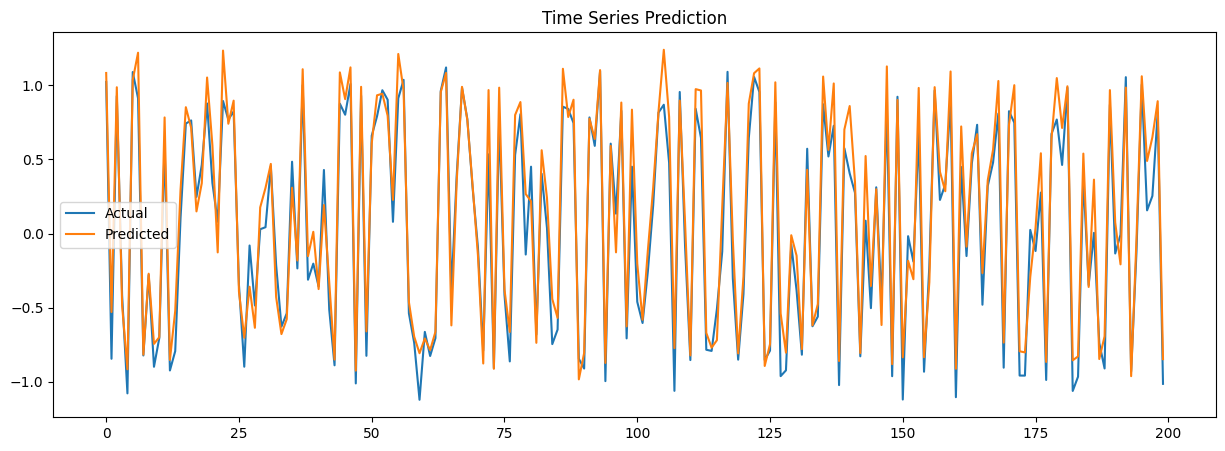

In [32]:
# Plotting
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Time Series Prediction')
plt.legend()
plt.show()

In [37]:
predictions_scaled_up[:5],y_test[:5]

(array([[ 0.9517929 ],
        [-0.59927124],
        [ 0.8441903 ],
        [-0.5531594 ],
        [-1.0396847 ]], dtype=float32),
 array([[ 1.02219448],
        [-0.84385962],
        [ 0.92767353],
        [-0.4174078 ],
        [-1.07710113]]))

In [33]:

mse = mean_squared_error(y_test , predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.031673956595417566


SyntaxError: unterminated string literal (detected at line 2) (3040327754.py, line 2)

# LSTM Classical Approach

Epoch 0, Loss: 0.6029279828071594, Test Loss: 0.6054651737213135
Epoch 1, Loss: 0.4948294758796692, Test Loss: 0.49562662839889526
Epoch 2, Loss: 0.4027059078216553, Test Loss: 0.4006668031215668
Epoch 3, Loss: 0.32182925939559937, Test Loss: 0.3150365948677063
Epoch 4, Loss: 0.23191596567630768, Test Loss: 0.22007037699222565
Epoch 5, Loss: 0.13210013508796692, Test Loss: 0.12250294536352158
Epoch 6, Loss: 0.05590393394231796, Test Loss: 0.05351634323596954
Epoch 7, Loss: 0.020566372200846672, Test Loss: 0.02340831235051155
Epoch 8, Loss: 0.024922551587224007, Test Loss: 0.029116692021489143
Epoch 9, Loss: 0.02684505470097065, Test Loss: 0.03045075573027134
Epoch 10, Loss: 0.02171601727604866, Test Loss: 0.02536172792315483
Epoch 11, Loss: 0.01962372474372387, Test Loss: 0.022913888096809387
Epoch 12, Loss: 0.019549677148461342, Test Loss: 0.02288464456796646
Epoch 13, Loss: 0.01927294209599495, Test Loss: 0.022880949079990387
Epoch 14, Loss: 0.019231611862778664, Test Loss: 0.0227785

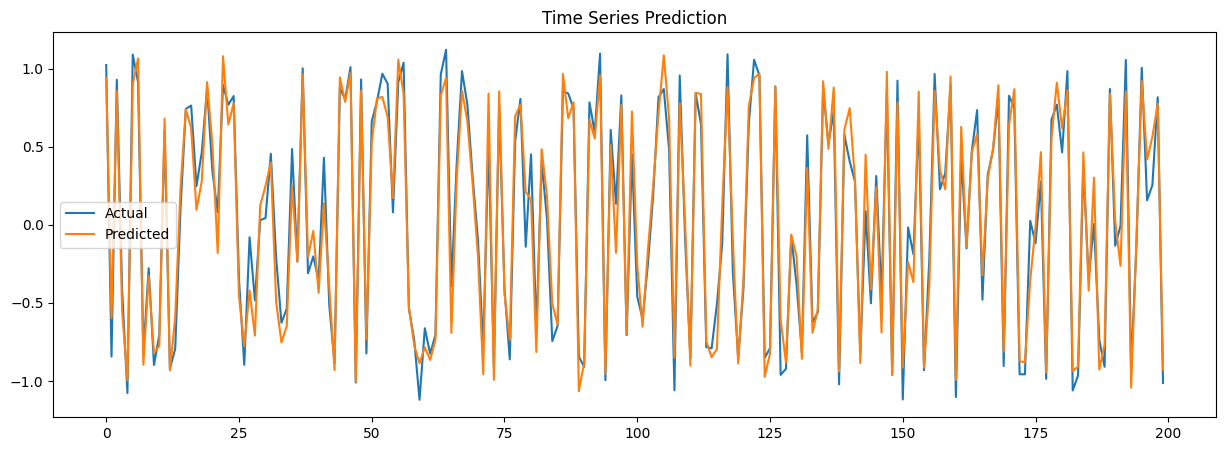

Mean Squared Error: 0.02281228144215612


In [143]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# Generate a synthetic time series dataset
np.random.seed(0)
time = np.arange(0, 100, 0.1)
amplitude = np.sin(time) + np.random.normal(0, 0.1, len(time))
X = amplitude[:-1]
y = amplitude[1:]

# Reshape data for the model
X = X.reshape(-1, 1, 1)
y = y.reshape(-1, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define an LSTM with Attention mechanism
class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(LSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out).squeeze(-1), dim=-1)
        context_vector = torch.sum(lstm_out * attention_weights.unsqueeze(-1), dim=1)
        out = self.fc(context_vector)
        return out

# Instantiate the model
model = LSTMAttention(input_dim=1, hidden_dim=4)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_loss_list,test_loss_list = [],[]

# Training the model
epochs = 70


#epochs = 100
for epoch in range(epochs):
    num_train = X_train.shape[0]
    batch_size=100
    for i in range(0, num_train, batch_size):
        # Create mini-batch            
        feats_batch = X_train_tensor[i:i + batch_size]
        #print("feats_type",type(feats_batch))
        Y_batch = y_train_tensor[i:i + batch_size]
        #print("Y_batch type",type(feats_batch))
        # Print shapes for debugging
        #print("weights shape:", weights.shape)
        #print("bias shape:", bias.shape)
        if feats_batch.shape[0]!=100:
              break
        
        model.train()
        optimizer.zero_grad()
        output = model(feats_batch)
        loss = criterion(output, Y_batch)
        loss.backward()
        optimizer.step()
        #print("feats_train_batch shape:", feats_batch.shape,type(feats_batch))
        #print("Y_train_batch shape:", Y_batch.shape,type(feats_batch)
        # Update the weights by one optimizer step
        #weights, bias, _, _ = opt.step(cost, weights, bias, feats_batch, Y_batch)
        #if i %100==0:


#        
#for epoch in range(epochs):
#    model.train()
#    optimizer.zero_grad()
#    output = model(X_train_tensor)
#    loss = criterion(output, y_train_tensor)
#    loss.backward()
#    optimizer.step()
#
    if epoch % 1 == 0:
        model.eval()
        test_pred = model(X_test_tensor)
        test_loss = criterion(test_pred, y_test_tensor)
        #print("test_pred, y_test_tensor",test_pred,y_test_tensor)
        print(f'Epoch {epoch}, Loss: {loss.item()}, Test Loss: {test_loss.item()}')
        train_loss_list.append(loss.item())
        test_loss_list.append(test_loss.item())
# Predictions
model.eval()
predictions = model(X_test_tensor).detach().numpy()

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Time Series Prediction')
plt.legend()
plt.show()

# Metrics
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Interpretation
# The plot shows how well the LSTM model with attention mechanism can predict the future values of a time series.
# The MSE provides a quantitative measure of the model's prediction accuracy.

In [144]:
len(train_loss_list),len(test_loss_list)

(70, 70)

In [145]:
len(train_qsan)

0

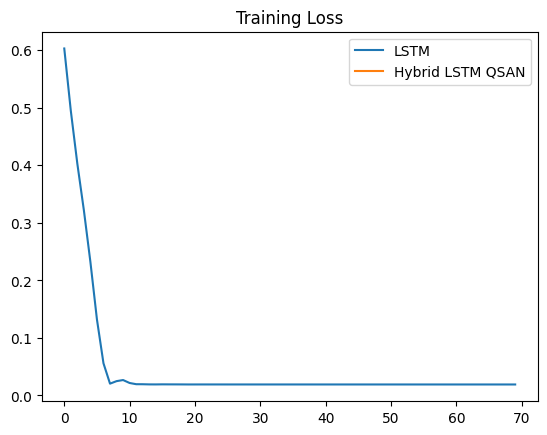

In [146]:
# Plotting_train

#plt.figure(figsize=(15, 5))
plt.plot(train_loss_list, label='LSTM')
plt.plot(train_qsan, label='Hybrid LSTM QSAN')
plt.title('Training Loss')
plt.legend()
plt.show()

In [30]:
test_qsan

array([0.03413988, 0.02875257, 0.02522156, 0.02298532, 0.02146279,
       0.02045687, 0.01993085, 0.01988211, 0.02028028, 0.02102505,
       0.02193507, 0.02279032, 0.02341559, 0.02373872, 0.02378502,
       0.02363638, 0.02339082, 0.02313485, 0.02292859, 0.02280218,
       0.02276162, 0.02279975, 0.02290572, 0.02306877, 0.02327612,
       0.02350839, 0.02373656, 0.02392322, 0.0240291 , 0.02402318,
       0.02389219, 0.02364572, 0.02331449, 0.02294332, 0.02258131,
       0.02227284, 0.0220512 , 0.02193583, 0.0219326 , 0.02203555,
       0.02222877, 0.02248795, 0.02278193, 0.0230754 , 0.0233331 ,
       0.02352512, 0.02363192, 0.02364745, 0.02357934, 0.02344628,
       0.02327361, 0.0230885 , 0.02291579, 0.02277515, 0.0226795 ,
       0.02263434, 0.02263792, 0.02268199, 0.02275328, 0.02283585,
       0.02291407, 0.02297547, 0.02301282, 0.02302499, 0.02301614,
       0.02299403, 0.02296775, 0.0229456 , 0.02293358, 0.02293452])

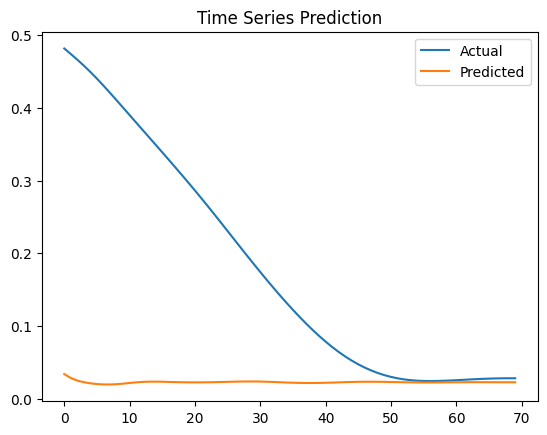

In [29]:
# Plotting
#plt.figure(figsize=(15, 5))
test_qsan = np.array(test_qsan)*0.079
plt.plot(test_loss_list, label='Actual')
plt.plot(test_qsan, label='Predicted')
plt.title('Time Series Prediction')
plt.legend()
plt.show()